# `pyEQL` Tutorial: Calculating Osmotic Pressure

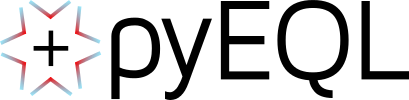

`pyEQL` is an open-source `python` library for solution chemistry calculations and ion properties developed by the [Kingsbury Lab](https://www.kingsburylab.org/) at Princeton University.

[Documentation](https://pyeql.readthedocs.io/en/latest/) | [How to Install](https://pyeql.readthedocs.io/en/latest/installation.html) | [GitHub](https://github.com/rkingsbury/pyEQL) 

## Installation

Uncomment and run the code cell below, if you do not already have `pyEQL`

In [1]:
# pip install pyEQL

## First, create a `Solution`

`pyEQL`'s built-in property database contains Pitzer model parameters for many simple (binary) electrolytes. If such parameters are available, `pyEQL` will use them by default.

In [2]:
from pyEQL import Solution
# 2 mol/L NaCl
s1 = Solution({"Na+": "2 mol/L", "Cl-": "2 mol/L"})

## Get the osmotic pressure

Note that the osmotic pressure (and most `Solution` properties) are returned as `pint` `Quantity` objects (see [Converting Units](https://pyeql.readthedocs.io/en/latest/units.html)).

In [3]:
s1.osmotic_pressure

10224795.514383134 <Unit('pascal')>

If you want the osmotic pressure in different units, or you only want the magnitude, use `to()` and `magnitude`, respectively

In [4]:
s1.osmotic_pressure.to('bar')

102.24795514383135 <Unit('bar')>

In [5]:
s1.osmotic_pressure.to('bar').magnitude

102.24795514383135

## Use a `for` loop for multiple calculations

You can rapidly get estimates for multiple concentrations (or temperatures, or solutes) by using a `for` loop. Notice how in the example below, we use [f-strings](https://realpython.com/python-f-strings/) to insert the desired concentration (from the `for` loop) into the argument passed to `Solution` and to print the results.

In [6]:
for conc in [0.1, 0.5, 1, 2, 4]:
    s1 = Solution({"Na+": f"{conc} mol/L", "Cl-": f"{conc} mol/L"})
    print(f"At C={conc:.1f} M, the osmotic pressure is {s1.osmotic_pressure.to('bar'):.2f}.")

At C=0.1 M, the osmotic pressure is 4.63 bar.
At C=0.5 M, the osmotic pressure is 23.07 bar.
At C=1.0 M, the osmotic pressure is 47.40 bar.
At C=2.0 M, the osmotic pressure is 102.25 bar.
At C=4.0 M, the osmotic pressure is 246.95 bar.


## Compare different modeling engines

`pyEQL` contains several different [modeling engines](https://pyeql.readthedocs.io/en/latest/engines.html) that can calculate activity coefficients or osmotic pressures. At present, there are three options:

1. The `native` or built-in engine, which includes an implementation of the Piter model (Default).
2. the `phreeqc` engine, which utilizes the USGS PHREEQC model with the `phreeqc.dat` database.
3. An ideal solution model (`ideal`) which does not account for solution non-ideality.

You select a modeling engine using the `engine` keyword argument when you create a `Solution`. Let's compare the preditions from the three models.

In [7]:
s_ideal = Solution({"Na+": "2 mol/L", "Cl-": "2 mol/L"}, engine='ideal')
s_phreeqc = Solution({"Na+": "2 mol/L", "Cl-": "2 mol/L"}, engine='phreeqc')
s_native = Solution({"Na+": "2 mol/L", "Cl-": "2 mol/L"}, engine='native')

In [8]:
s_ideal.osmotic_pressure.to('bar')

WARNING 2023-11-10 11:48:57,162 solution.py get_water_activity 1934 Pitzer parameters not found. Water activity set equal to mole fraction


95.73878424096024 <Unit('bar')>

In [9]:
s_phreeqc.osmotic_pressure.to('bar')

95.73878424096024 <Unit('bar')>

In [10]:
s_native.osmotic_pressure.to('bar')

102.24795514383135 <Unit('bar')>

## Plot the comparison vs. experiment

We can make a plot showing how the 3 models compare by combining the two previous steps (using a `for` loop plus changing the `engine` keyword argument. Note that this example makes use of `matplotlib` for plotting.

In [11]:
# create empty lists to hold the results
pi_ideal = []
pi_phreeqc = []
pi_native = []

concentrations = [0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.4, 2, 2.5, 3, 3.5, 4]

for conc in concentrations:
    s_ideal = Solution({"Na+": f"{conc} mol/kg", "Cl-": f"{conc} mol/kg"}, engine='ideal')
    s_phreeqc = Solution({"Na+": f"{conc} mol/kg", "Cl-": f"{conc} mol/kg"}, engine='phreeqc')
    s_native = Solution({"Na+": f"{conc} mol/kg", "Cl-": f"{conc} mol/kg"}, engine='native')
    
    # store the osmotic pressures in the respective lists
    # note that we have to just store the .magnitude because matplotlib can't plot Quantity
    pi_ideal.append(s_ideal.osmotic_pressure.to('bar').magnitude)
    pi_phreeqc.append(s_phreeqc.osmotic_pressure.to('bar').magnitude)
    pi_native.append(s_native.osmotic_pressure.to('bar').magnitude)

We will include experimental data from the [IDST](https://idst.inl.gov/) as a benchmark. The IDST gives us water activity, which we convert into osmotic pressure according to

$$
\Pi = -\frac{RT}{V_{w}} \ln a_{w}
$$

Where $\Pi$ is the osmotic pressure, $V_{w}$ is the partial molar volume of water (18.2 cm**3/mol), and $a_{w}$ is the water
            activity.

In [12]:
import math
# water activity at [0.1, 0.2, 0.3, 0.4, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4] mol/kg
water_activity_idst = [0.99664, 0.993353, 0.99008, 0.986804, 0.98352, 0.966828, 0.953166, 0.93191, 0.913072, 0.89347, 0.872859, 0.85133]

# calculate osmotic pressure as -RT/Vw ln(a_w). Factor 10 converts to bar.
pi_idst = [-8.314*298.15/18.2 * math.log(a) * 10 for a in water_activity_idst]

Text(0.5, 0.98, 'pyEQL prediction of NaCl osmotic pressure')

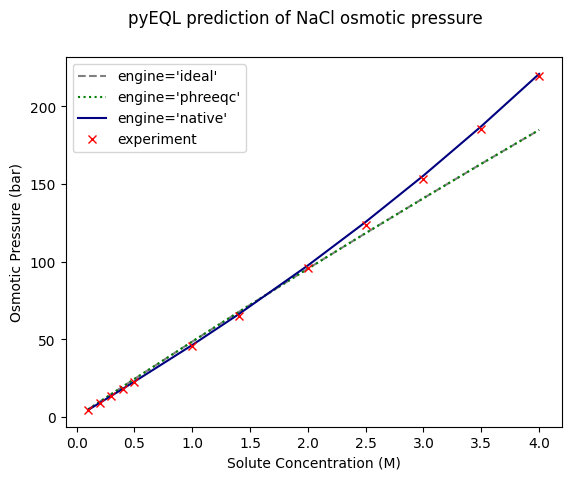

In [13]:
# plot the results!
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(concentrations, pi_ideal, label="engine='ideal'", ls='--', color='gray')
ax.plot(concentrations, pi_phreeqc, label="engine='phreeqc'", ls=':', color='green')
ax.plot(concentrations, pi_native, label="engine='native'", ls='-', color='navy')
ax.plot(concentrations, pi_idst, label="experiment", ls='', color='red', marker="x")
ax.legend()
ax.set_xlabel('Solute Concentration (M)')
ax.set_ylabel('Osmotic Pressure (bar)')
fig.suptitle('pyEQL prediction of NaCl osmotic pressure')